In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stefanoleone992/fifa-23-complete-player-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fifa-23-complete-player-dataset


In [42]:
# Re-import necessary modules after crash
import pandas as pd
import os

# Redefine dataset path
dataset_path = "/root/.cache/kagglehub/datasets/stefanoleone992/fifa-23-complete-player-dataset/versions/1"

# Feasibility Study – Predicting Soccer Player Position from Attributes (FIFA 23)

## Define Project

**🔗 Project Link**  
[Kaggle Dataset – FIFA 23 Complete Player Dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-23-complete-player-dataset)

**📝 Project Summary**  
This project builds a supervised machine learning model to predict a soccer player’s **primary position group** (Forward, Midfielder, Defender, or Goalkeeper) based on technical and physical attributes in the FIFA 23 dataset. This can help scouts and coaches make better data-informed decisions about lineup and player development.

**📊 Data Description**  
The dataset includes over 19,000 players with 100+ features ranging from numerical stats (pace, dribbling, defending, etc.) to categorical info (team, nationality, preferred foot). We will clean, transform, and group this data for modeling.

**🧠 Machine Learning Task**  
This is a **Supervised Multiclass Classification** problem with 4 target classes: FWD, MID, DEF, GK.


In [3]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/stefanoleone992/fifa-23-complete-player-dataset/versions/1


In [4]:
dataset_path = "/root/.cache/kagglehub/datasets/stefanoleone992/fifa-23-complete-player-dataset/versions/1"
os.listdir(dataset_path)

['male_teams.csv',
 'male_players.csv',
 'female_teams.csv',
 'female_players.csv',
 'male_coaches.csv',
 'male_players (legacy).csv',
 'female_players (legacy).csv',
 'female_coaches.csv']

### 📂 Dataset Scope and Justification

While the full FIFA 23 dataset includes both male and female players, we are using **`male_players.csv`** as our primary dataset for this feasibility study. This decision is based on the following reasons:

- ⚽ **Consistency in Features**: The male player dataset includes the most complete set of technical and physical attributes needed for position classification.
- 📊 **Sample Size**: It contains significantly more rows (player entries), which helps improve model training and generalization.
- 🤖 **Reduced Noise**: Mixing male and female datasets could introduce structural or statistical differences (e.g., league, competition level) that may complicate training a clean model without substantial preprocessing or normalization.
- 🔍 **Clearer Labeling**: Position data in the male dataset is more standardized and aligned with mainstream position groupings (FWD, MID, DEF, GK).

Female player data or coaches/team files may be used in future expansions, but for the initial model development and feasibility testing, focusing on **`male_players.csv`** ensures better feature quality and less data fragmentation.

## Data Loading and Initial Look

To begin assessing the data quality, we first load the FIFA 23 dataset and check the number of data points (rows) and features (columns).

In [43]:
# Load just the first 1000 rows to avoid RAM crash
df_sample = pd.read_csv(dataset_path + "/male_players.csv", nrows=1000)

df_raw = df_sample.copy()

# Show shape
print("Sample shape (rows, columns):", df_sample.shape)

df_sample.head()

Sample shape (rows, columns): (1000, 110)


player_id                                player_url  fifa_version  \
0     158023        /player/158023/lionel-messi/230009            23   
1     165153       /player/165153/karim-benzema/230009            23   
2     188545  /player/188545/robert-lewandowski/230009            23   
3     192985     /player/192985/kevin-de-bruyne/230009            23   
4     231747       /player/231747/kylian-mbappe/230009            23   

   fifa_update fifa_update_date      short_name  \
0            9       2023-01-13        L. Messi   
1            9       2023-01-13      K. Benzema   
2            9       2023-01-13  R. Lewandowski   
3            9       2023-01-13    K. De Bruyne   
4            9       2023-01-13       K. Mbappé   

                        long_name player_positions  overall  potential  ...  \
0  Lionel Andrés Messi Cuccittini               RW       91         91  ...   
1                   Karim Benzema           CF, ST       91         91  ...   
2              Robert Lewandowski               ST       91         91  ...   
3                 Kevin De Bruyne          CM, CAM       91         91  ...   
4            Kylian Mbappé Lottin           ST, LW       91         95  ...   

    cdm   rdm   rwb    lb   lcb    cb   rcb    rb    gk  \
0  63+3  63+3  64+3  59+3  50+3  50+3  50+3  59+3  19+3   
1  64+3  64+3  64+3  60+3  55+3  55+3  55+3  60+3  18+3   
2  66+3  66+3  64+3  61+3  60+3  60+3  60+3  61+3  19+3   
3  79+3  79+3  78+3  74+3  68+3  68+3  68+3  74+3  21+3   
4  63+3  63+3  67+3  63+3  54+3  54+3  54+3  63+3  18+3   

                                     player_face_url  
0  https://cdn.sofifa.net/players/158/023/23_120.png  
1  https://cdn.sofifa.net/players/165/153/23_120.png  
2  https://cdn.sofifa.net/players/188/545/23_120.png  
3  https://cdn.sofifa.net/players/192/985/23_120.png  
4  https://cdn.sofifa.net/players/231/747/23_120.png  

[5 rows x 110 columns]

### Missing Values?

In [6]:
df_sample.isnull().sum()[df_sample.isnull().sum() > 0]

value_eur                           8
wage_eur                            6
league_id                           6
league_name                         6
league_level                        6
club_team_id                        6
club_name                           6
club_position                       6
club_jersey_number                  6
club_loaned_from                  947
club_joined_date                   59
club_contract_valid_until_year      6
nation_team_id                    674
nation_position                   674
nation_jersey_number              674
release_clause_eur                 61
player_tags                       690
player_traits                      78
pace                              120
shooting                          120
passing                           120
dribbling                         120
defending                         120
physic                            120
goalkeeping_speed                 880
dtype: int64

In [7]:
categorical_cols = df_sample.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_sample.select_dtypes(include=['number']).columns.tolist()

print("Categorical features:", len(categorical_cols))
print("Numerical features:", len(numerical_cols))

Categorical features: 47
Numerical features: 63


### Feature Summary Table

Summary table that includes:
- Feature type (categorical or numerical)
- Value ranges or categories
- Missing value count
- Outlier check (for numerical columns)

In [10]:
# Helper function to detect outliers using IQR
def count_outliers(series):
    if pd.api.types.is_numeric_dtype(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return ((series < lower) | (series > upper)).sum()
    else:
        return np.nan  # not applicable

# Build feature summary table
summary = []

for col in df_sample.columns:
    col_type = 'categorical' if col in categorical_cols else 'numerical'
    unique_vals = df_sample[col].unique()
    if col_type == 'categorical':
        val_summary = ", ".join(map(str, unique_vals[:5])) + ("..." if len(unique_vals) > 5 else "")
    else:
        val_summary = f"{df_sample[col].min()} to {df_sample[col].max()}"

    summary.append({
        "Feature": col,
        "Type": col_type,
        "Values": val_summary,
        "Missing": df_sample[col].isnull().sum(),
        "Outliers": count_outliers(df_sample[col])
    })

feature_summary_df = pd.DataFrame(summary)

The summary table below gives us a quick overview of each feature in the sample dataset.
It helps us detect data quality issues and guides how we treat different feature types in preprocessing.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Display the summary table (first 20 rows)
feature_summary_df.head(20)

Feature         Type  \
0          player_id    numerical   
1         player_url  categorical   
2       fifa_version    numerical   
3        fifa_update    numerical   
4   fifa_update_date  categorical   
5         short_name  categorical   
6          long_name  categorical   
7   player_positions  categorical   
8            overall    numerical   
9          potential    numerical   
10         value_eur    numerical   
11          wage_eur    numerical   
12               age    numerical   
13               dob  categorical   
14         height_cm    numerical   
15         weight_kg    numerical   
16         league_id    numerical   
17       league_name  categorical   
18      league_level    numerical   
19      club_team_id    numerical   

                                               Values  Missing  Outliers  
0                                      1179 to 264240        0      15.0  
1   /player/158023/lionel-messi/230009, /player/16...        0       NaN  
2                                            23 to 23        0       0.0  
3                                              9 to 9        0       0.0  
4                                          2023-01-13        0       NaN  
5   L. Messi, K. Benzema, R. Lewandowski, K. De Br...        0       NaN  
6   Lionel Andrés Messi Cuccittini, Karim Benzema,...        0       NaN  
7                  RW, CF, ST, ST, CM, CAM, ST, LW...        0       NaN  
8                                            77 to 91        0      18.0  
9                                            77 to 95        0       8.0  
10                           1200000.0 to 190500000.0        8      64.0  
11                                  850.0 to 450000.0        6      71.0  
12                                           17 to 44        0      13.0  
13  1987-06-24, 1987-12-19, 1988-08-21, 1991-06-28...        0       NaN  
14                                         158 to 201        0       1.0  
15                                          56 to 103        0       4.0  
16                                      1.0 to 2012.0        6      81.0  
17  Ligue 1, La Liga, Premier League, Bundesliga, ...        6       NaN  
18                                         1.0 to 2.0        6       4.0  
19                                    1.0 to 116361.0        6     159.0

## Comparing Feature Distributions Across Classes

Visualizing how each feature varies across player positions (target classes) to identify which features might be useful for classification.


### Grouping Player Positions into Broader Categories

The original dataset contains many unique values in the `player_positions` column, such as "ST", "CAM", "RB", etc., and combinations like "ST, CF". To simplify our classification task and make our feature analysis more interpretable, we are grouping players into broader categories: Goalkeeper, Defender, Midfielder, and Forward. This makes our visualizations and later modeling steps clearer and more meaningful.

In [45]:
# Reset df_clean from df_sample, keeping only rows with valid player_positions
df_clean = df_sample[df_sample['player_positions'].notna()].copy()

# Remap position_group using the correct mapping logic
position_map = {
    'GK': 'Goalkeeper',
    'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender',
    'LWB': 'Defender', 'RWB': 'Defender',
    'CDM': 'Midfielder', 'CM': 'Midfielder', 'CAM': 'Midfielder',
    'LM': 'Midfielder', 'RM': 'Midfielder',
    'CF': 'Forward', 'ST': 'Forward', 'LW': 'Forward', 'RW': 'Forward'
}

def map_position(pos_str):
    if pd.isna(pos_str):
        return 'Unknown'
    primary = pos_str.split(',')[0].strip()
    return position_map.get(primary, 'Other')

df_clean['position_group'] = df_clean['player_positions'].apply(map_position)

# Sanity check
print(df_clean['position_group'].value_counts())


position_group
Midfielder    346
Defender      302
Forward       232
Goalkeeper    120
Name: count, dtype: int64


In [13]:
df_sample.dtypes

player_id            int64
player_url          object
fifa_version         int64
fifa_update          int64
fifa_update_date    object
                     ...  
cb                  object
rcb                 object
rb                  object
gk                  object
player_face_url     object
Length: 110, dtype: object

In [14]:
df_sample.isnull().sum().sort_values(ascending=False).head(25)

club_loaned_from                  947
goalkeeping_speed                 880
player_tags                       690
nation_position                   674
nation_jersey_number              674
nation_team_id                    674
shooting                          120
passing                           120
pace                              120
dribbling                         120
physic                            120
defending                         120
player_traits                      78
release_clause_eur                 61
club_joined_date                   59
value_eur                           8
league_level                        6
club_position                       6
club_name                           6
league_name                         6
club_jersey_number                  6
club_contract_valid_until_year      6
wage_eur                            6
league_id                           6
club_team_id                        6
dtype: int64

## Re-Visualizing Feature Distributions by Broad Position Groups

To better understand how player attributes differ by role, we re-plot distributions using the `position_group` categories (Goalkeeper, Defender, Midfielder, Forward). This time, we focus on numeric features that are appropriate for density plots—specifically, those with enough variation and no known plotting issues.

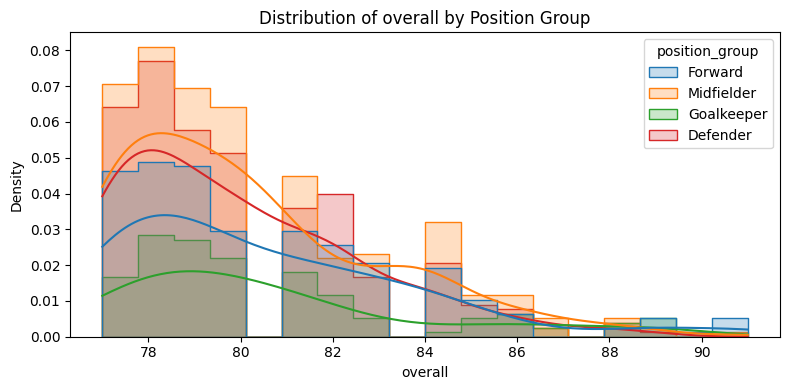

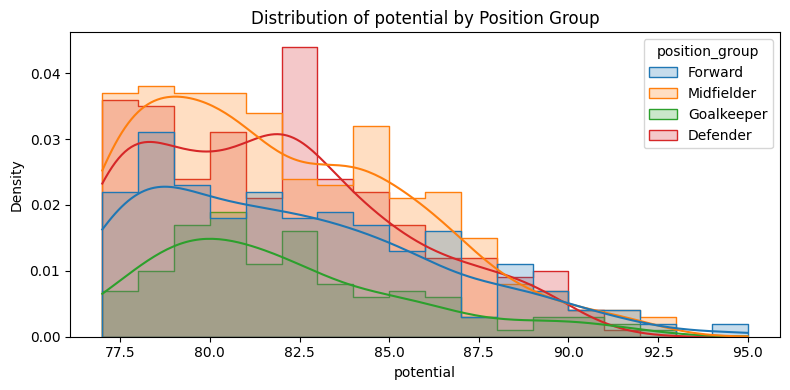

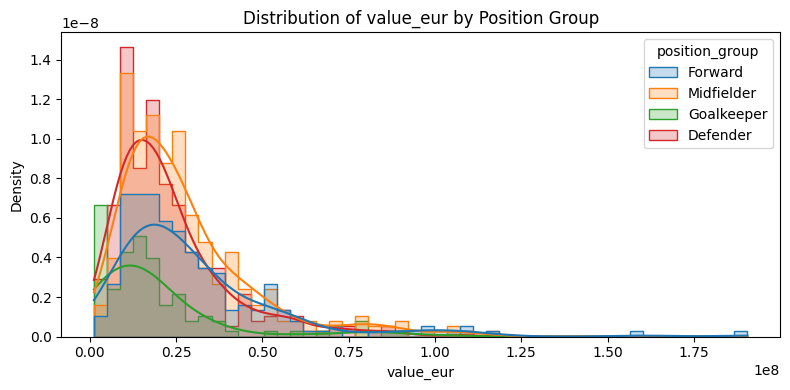

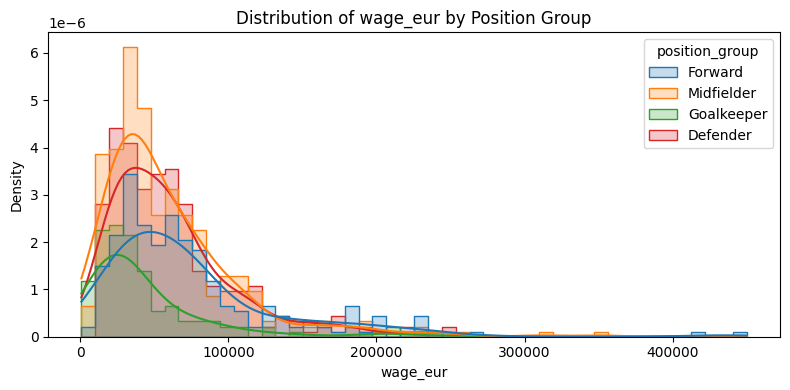

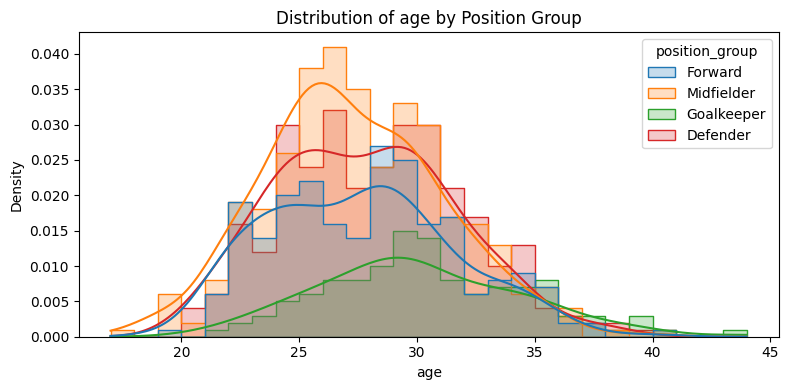

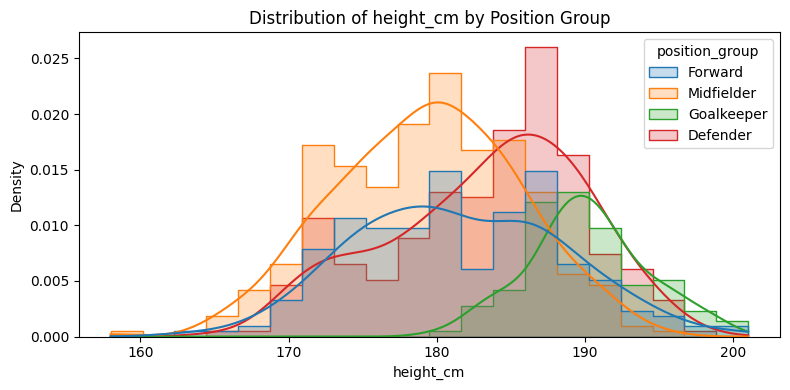

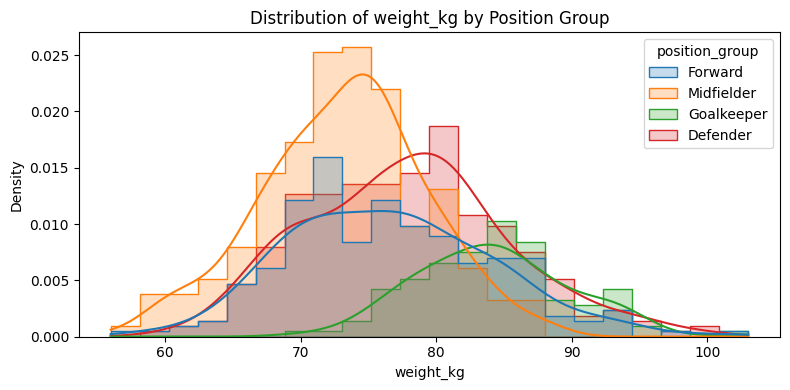

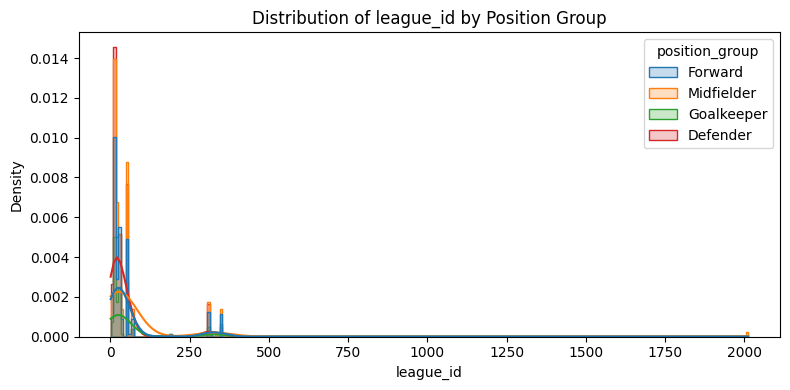

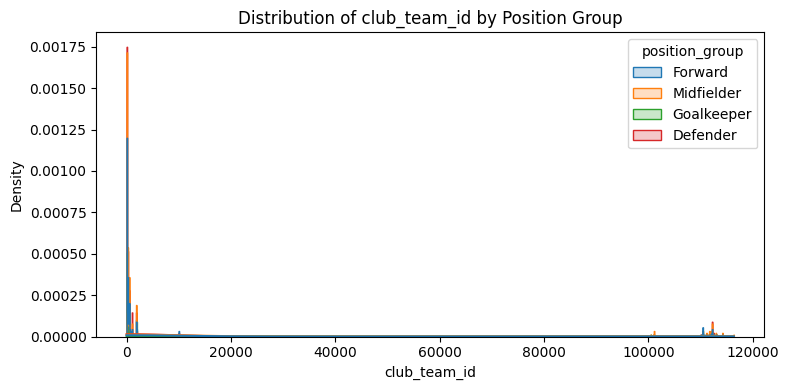

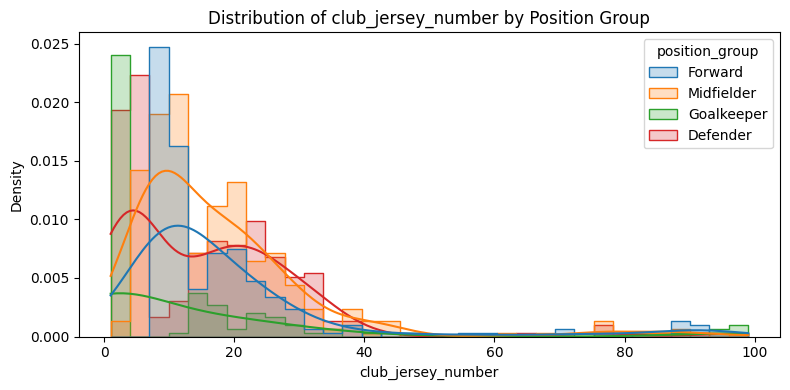

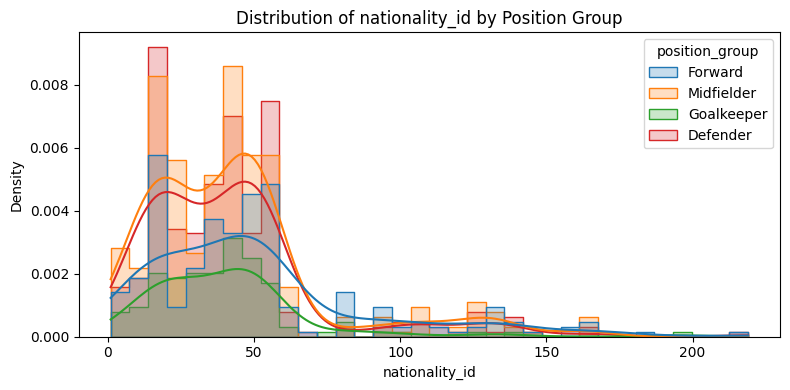

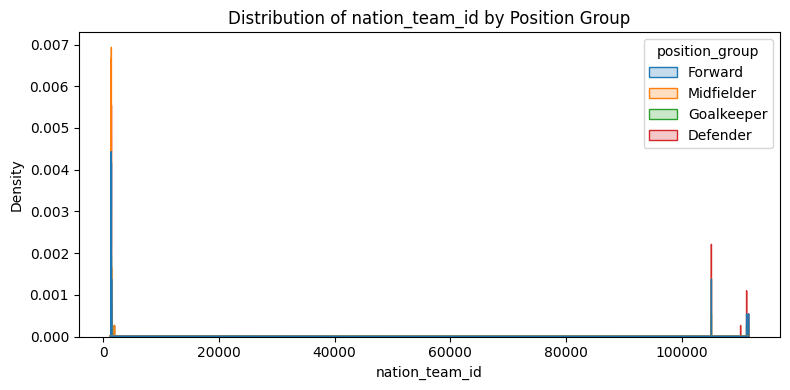

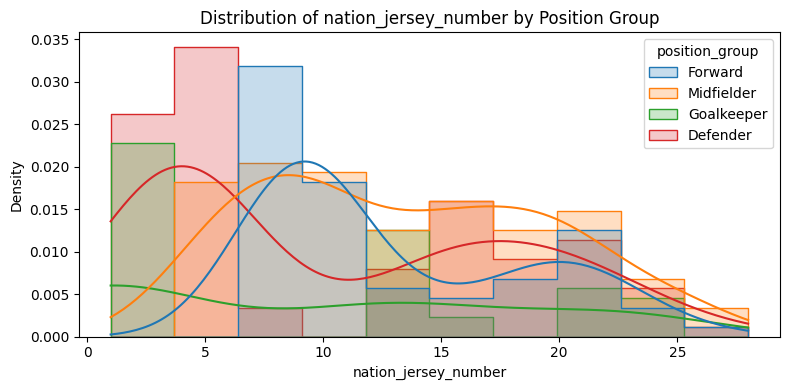

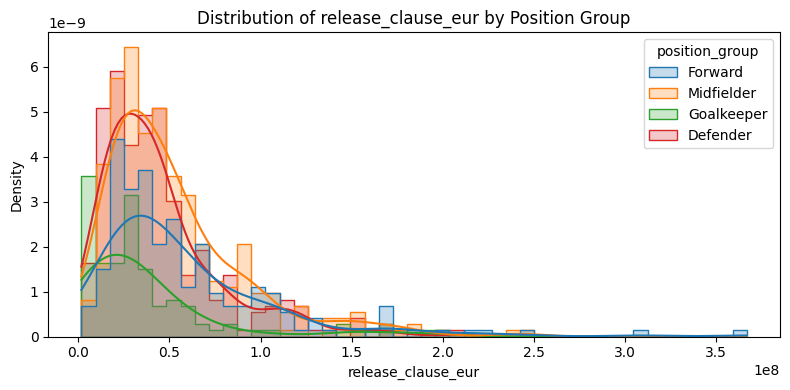

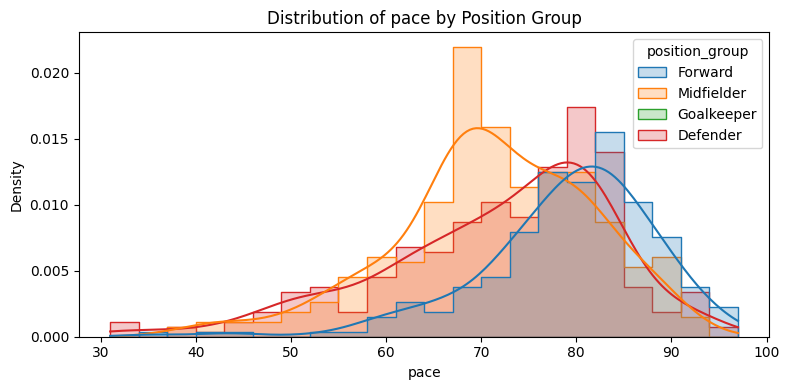

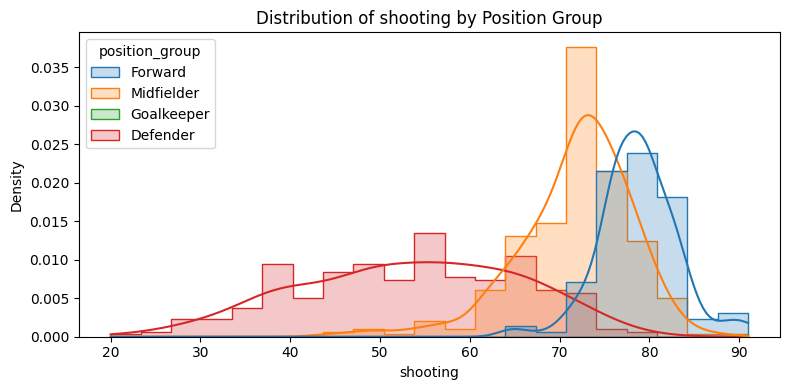

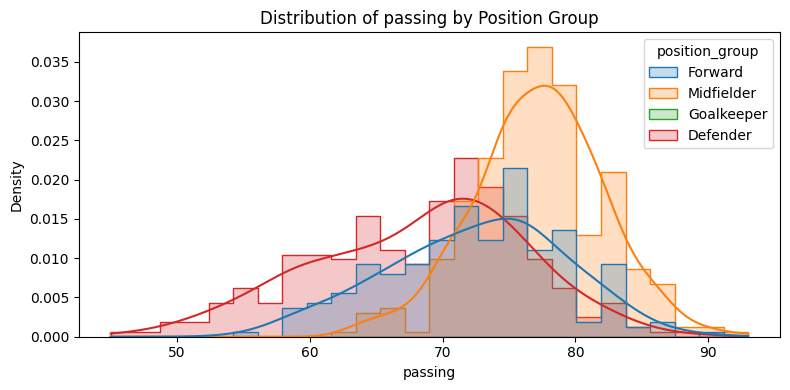

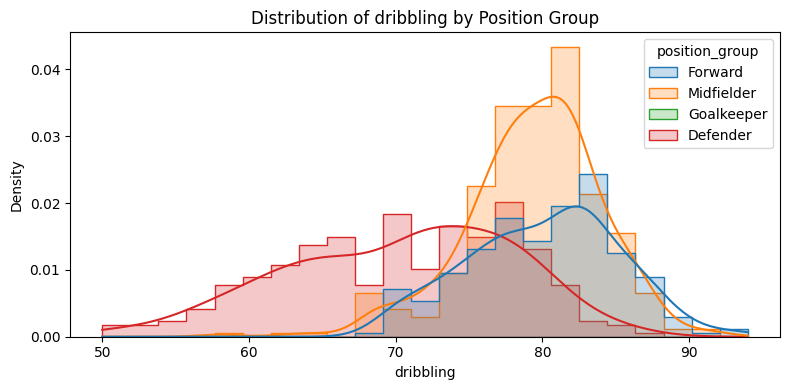

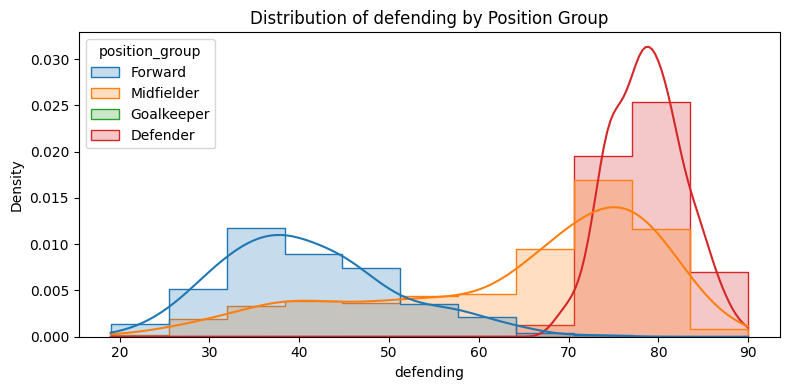

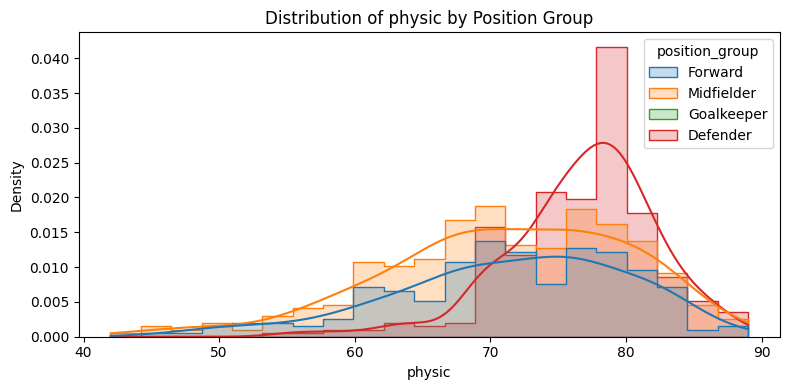

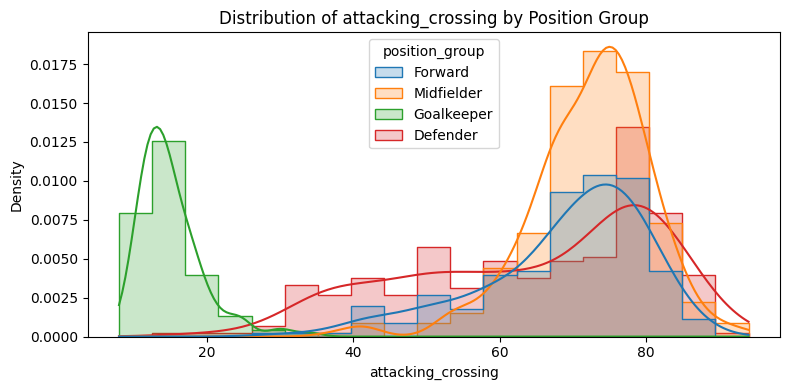

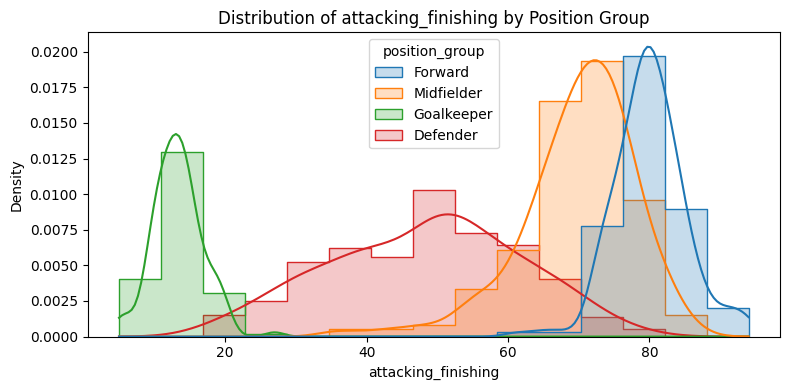

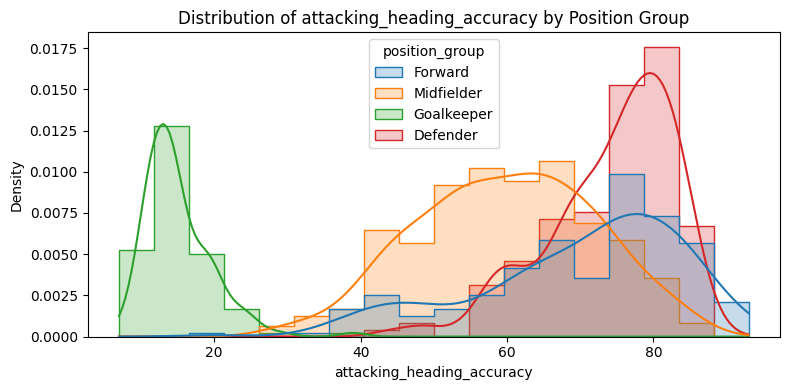

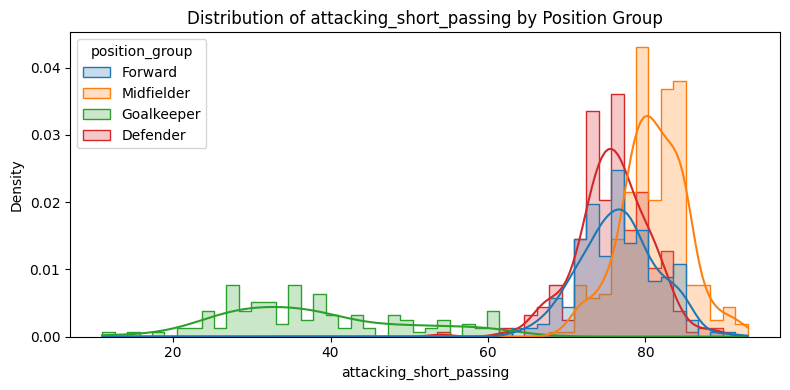

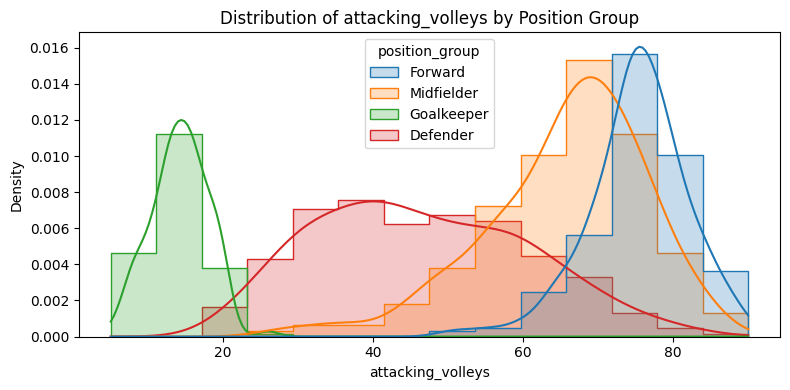

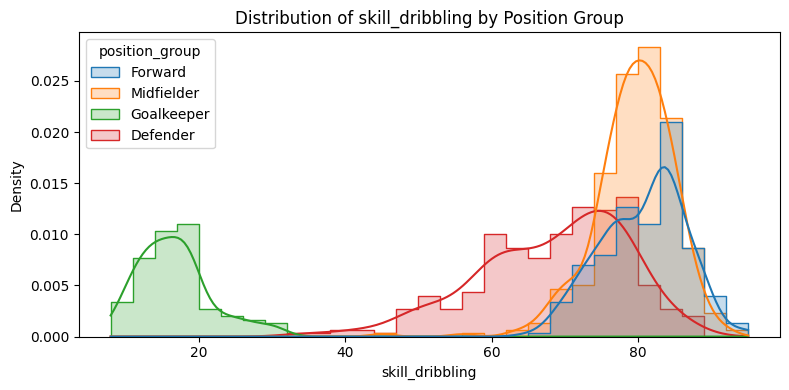

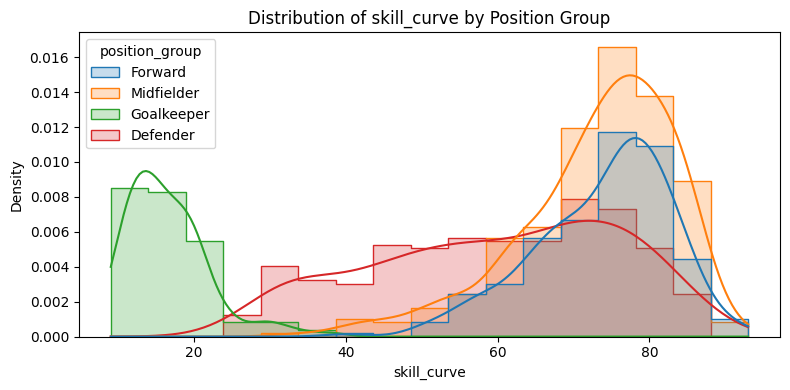

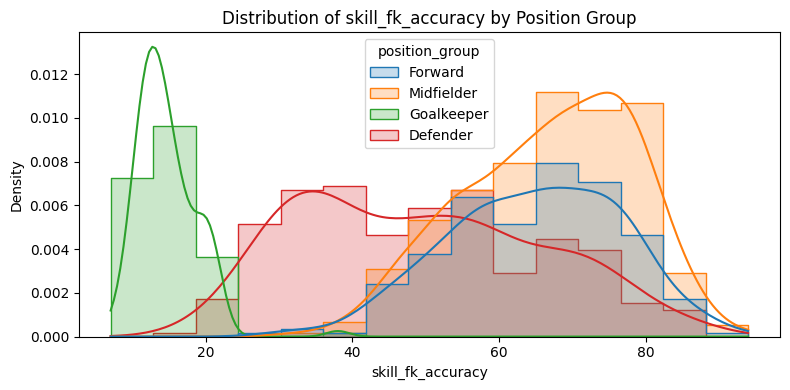

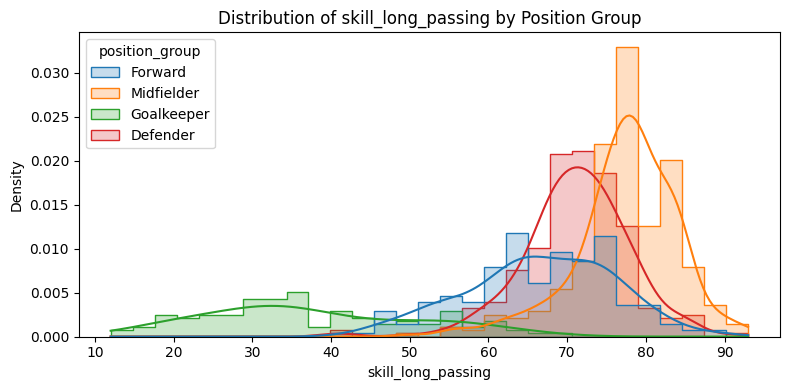

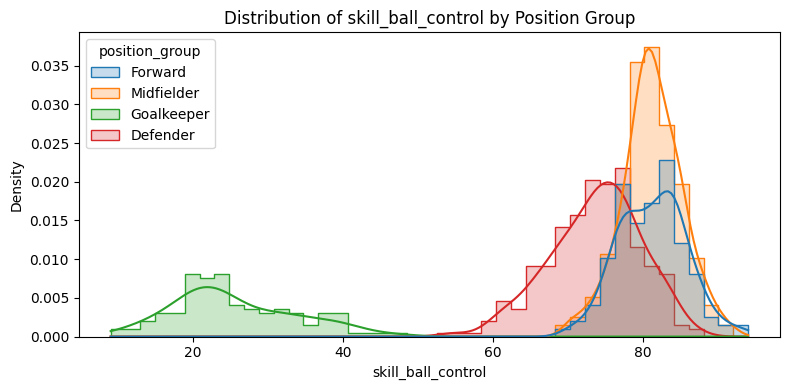

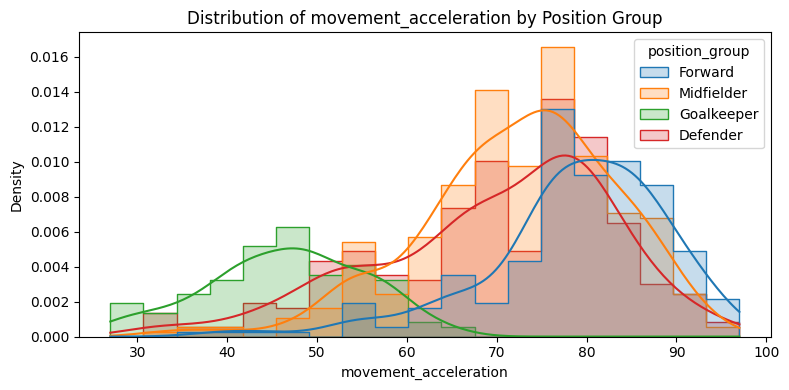

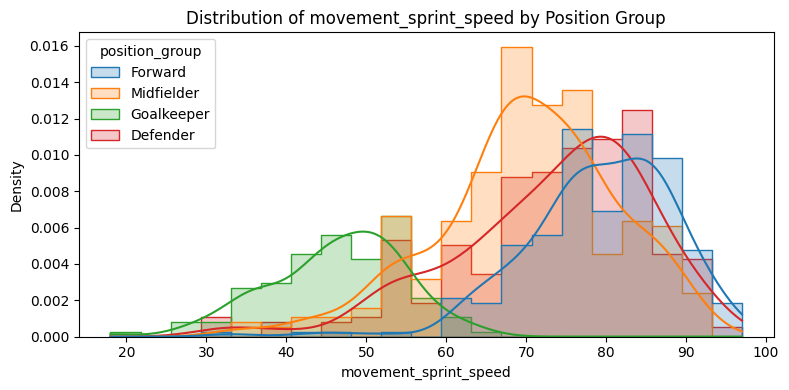

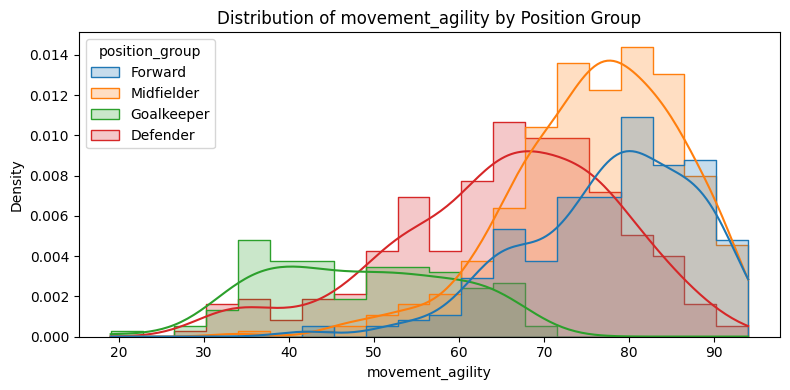

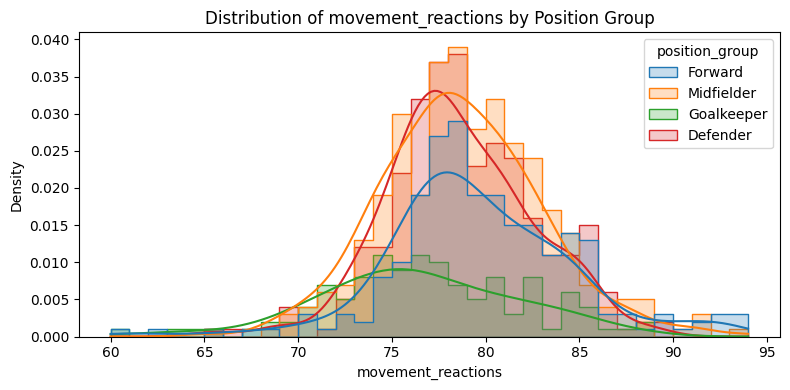

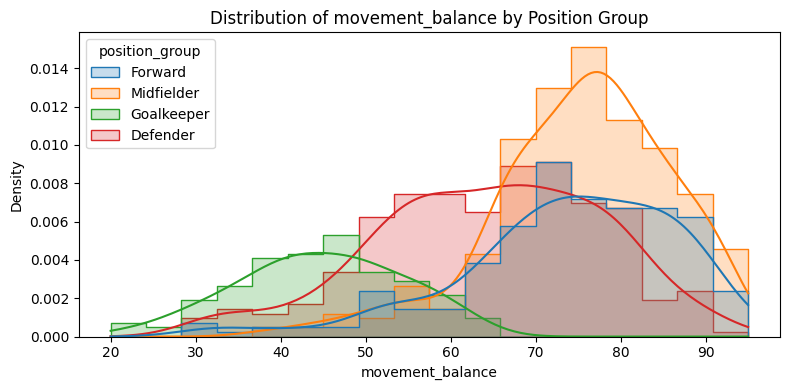

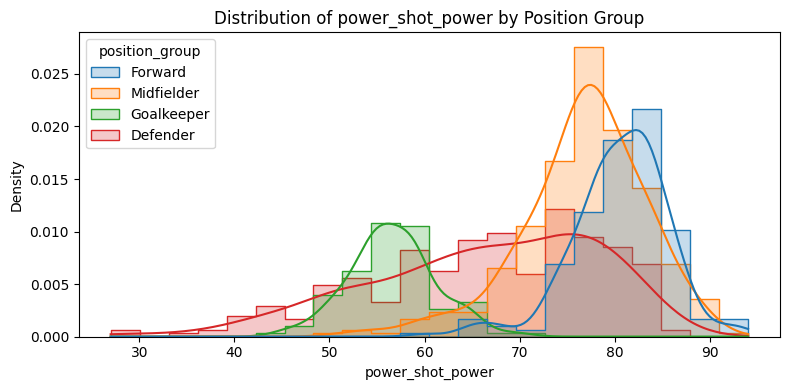

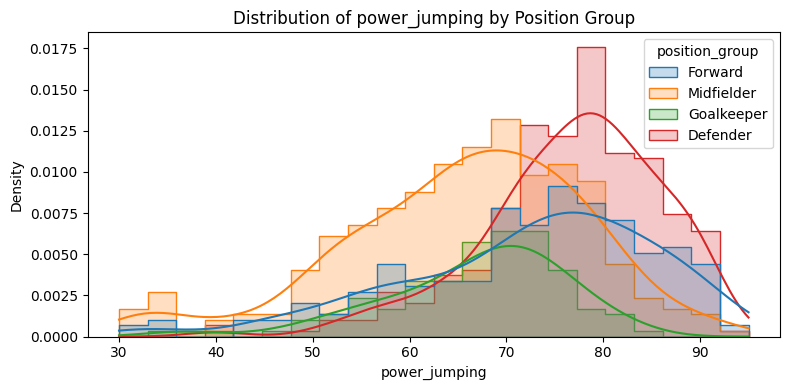

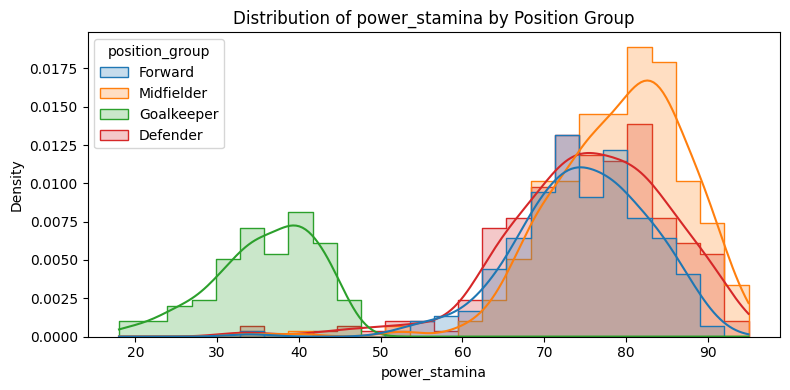

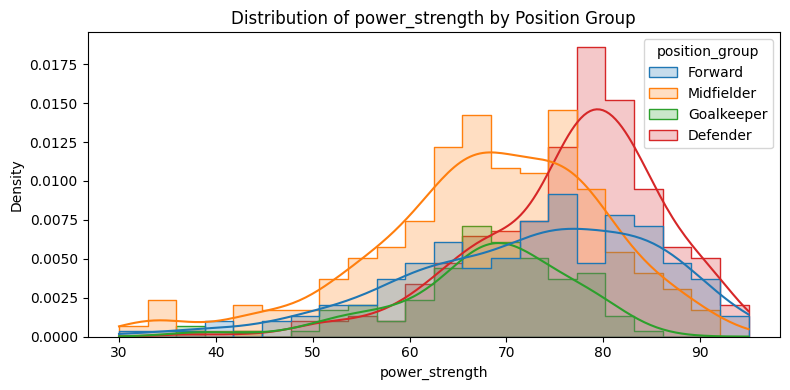

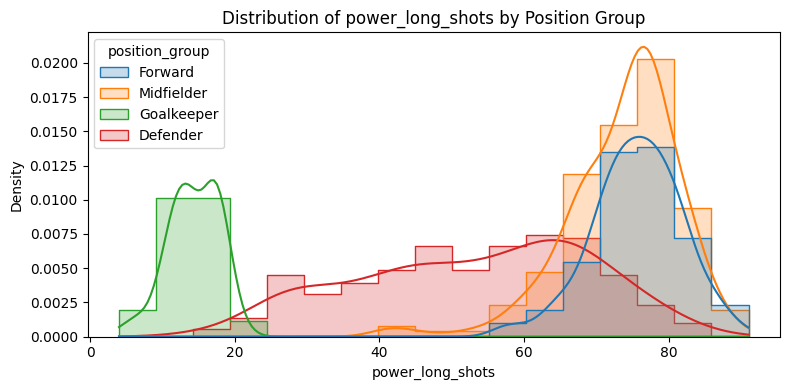

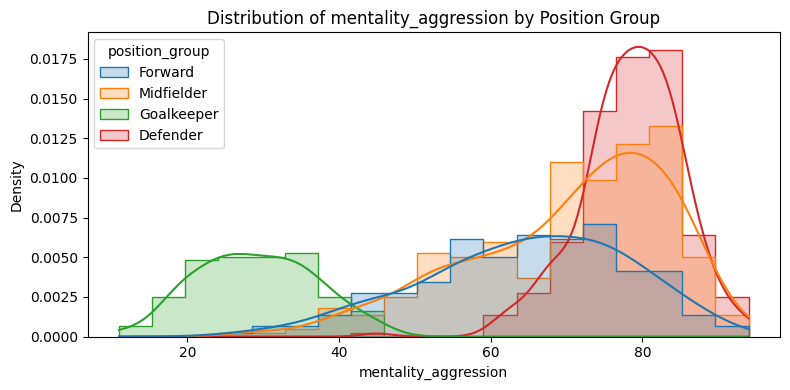

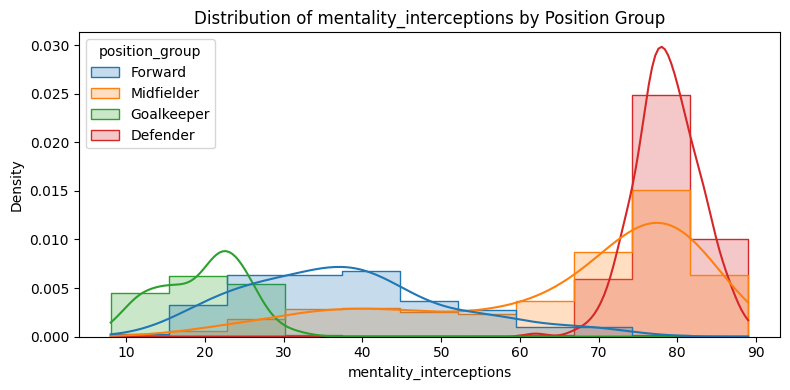

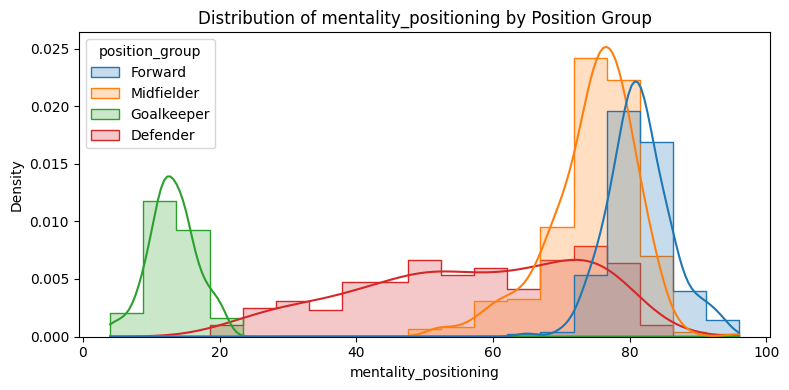

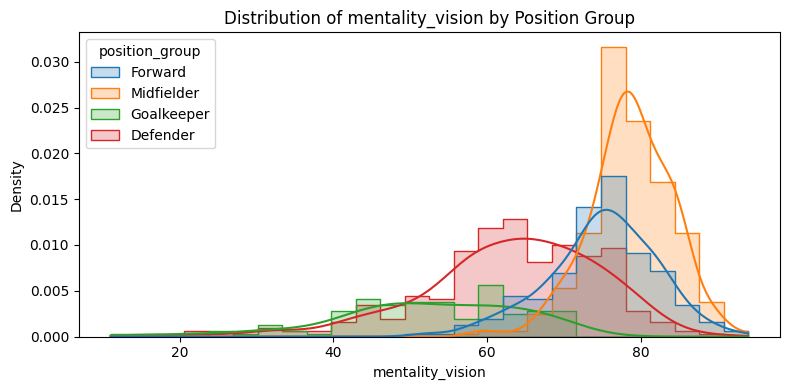

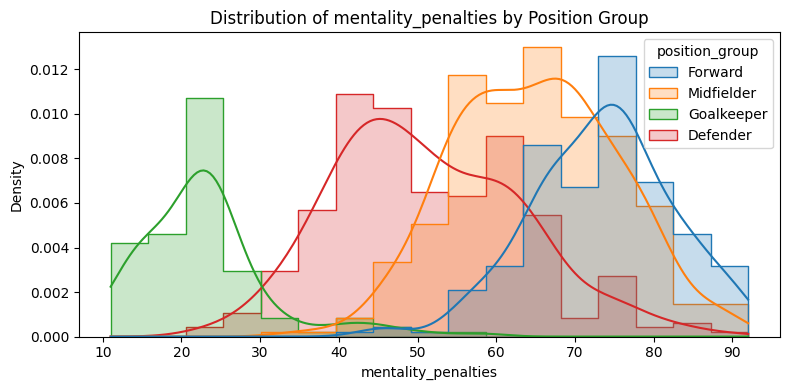

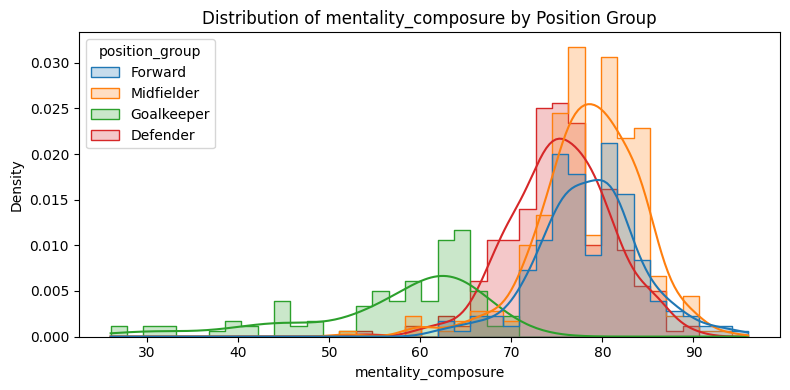

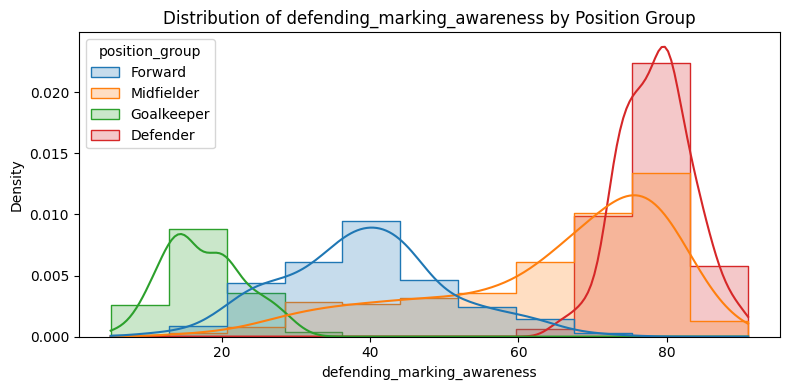

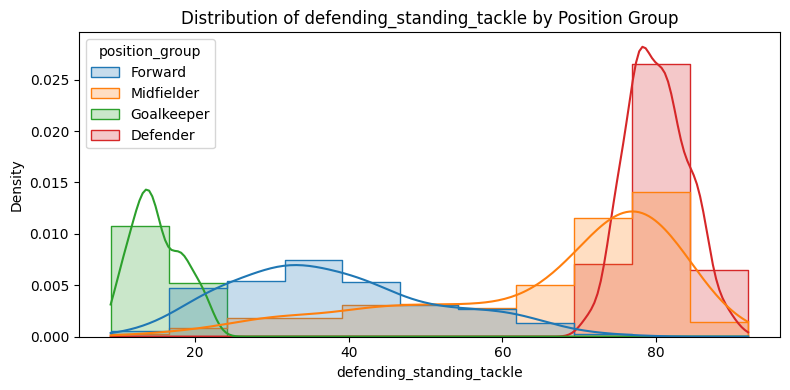

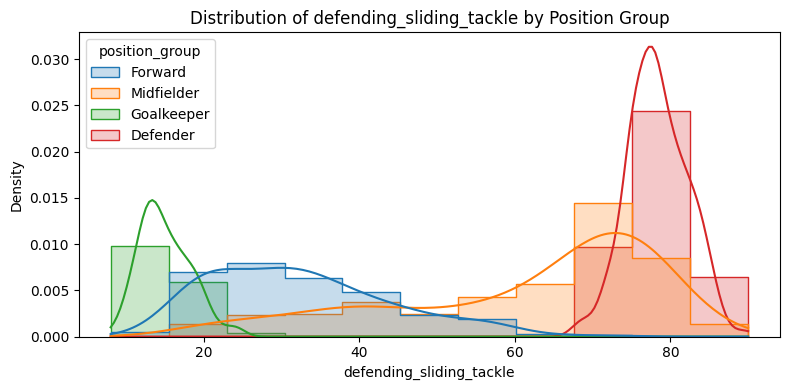

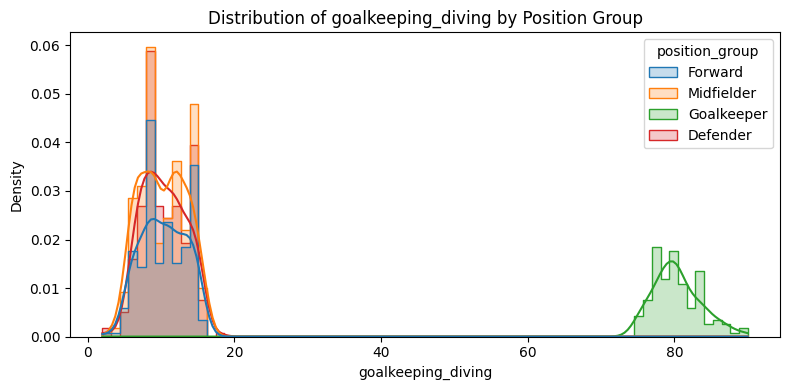

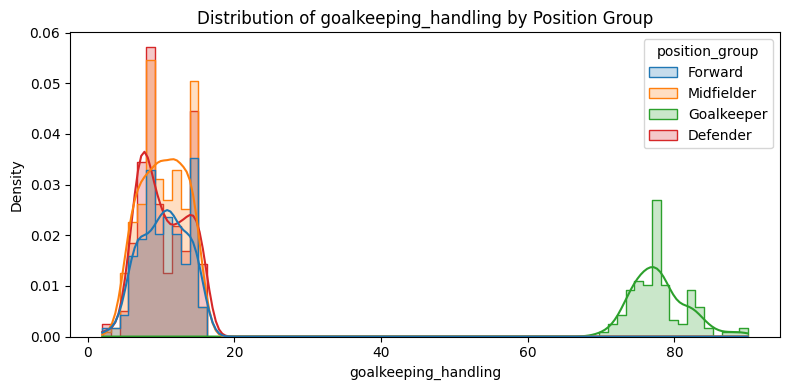

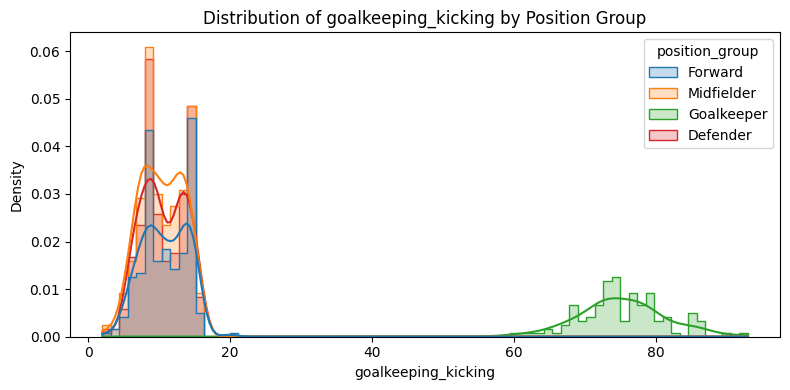

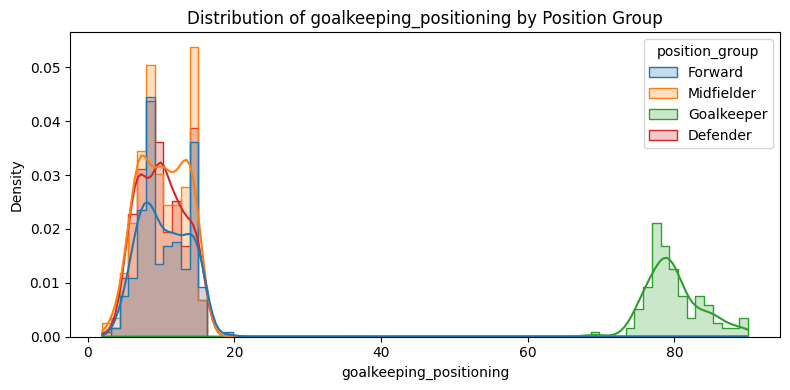

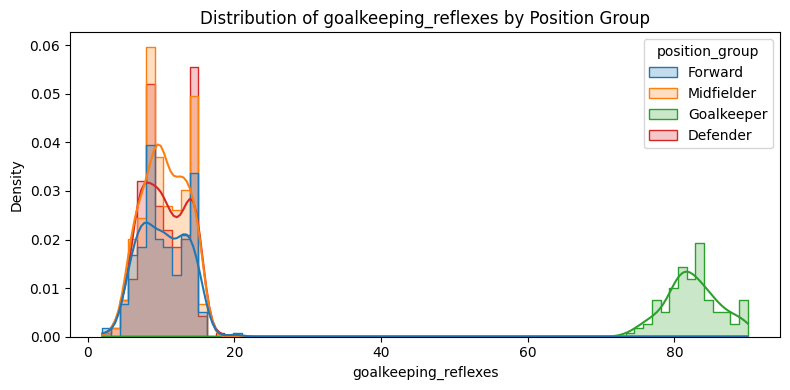

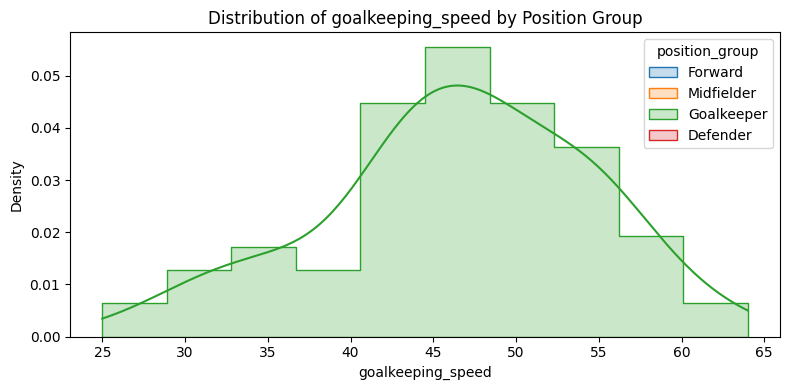

In [15]:
# Define new target column
target_col = 'position_group'

# Only keep useful numeric columns (remove problematic ones)
exclude_cols = ['player_id', 'fifa_version']  # Add more if needed

# Filter numeric columns that are not excluded and have enough unique values
plot_cols = [
    col for col in df_clean.columns
    if df_clean[col].dtype in ['float64', 'int64']
    and col != target_col
    and col not in exclude_cols
    and df_clean[col].nunique() > 10
]

# Plot filtered histograms
for col in plot_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_clean, x=col, hue=target_col, kde=True, element='step', stat='density')
    plt.title(f'Distribution of {col} by Position Group')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

**Note**: Some features (e.g., `fifa_version`) were excluded due to low variability or technical limitations with kernel density estimation.

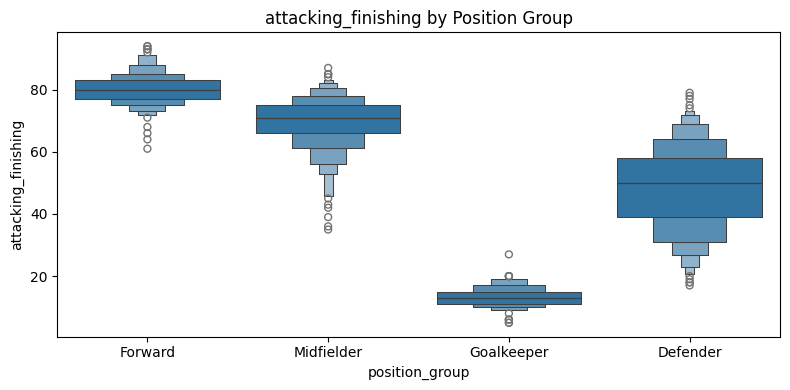

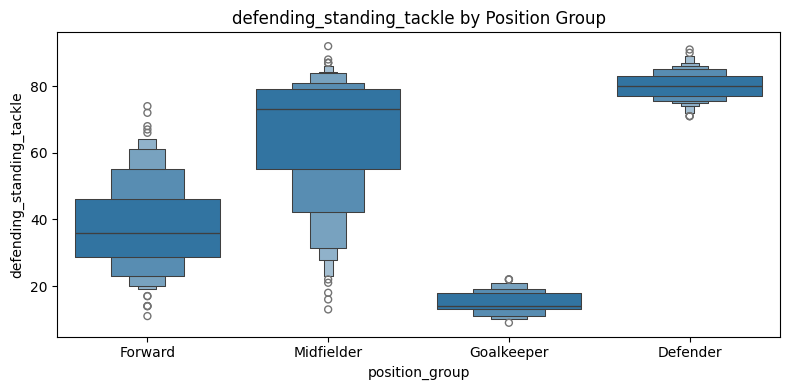

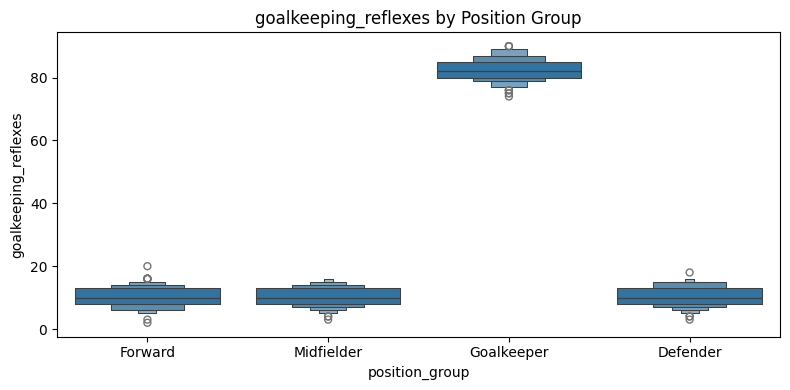

In [16]:
# Visualize top 3 features by position group using boxenplot
top_features = ['attacking_finishing', 'defending_standing_tackle', 'goalkeeping_reflexes']

for col in top_features:
    if col in df_clean.columns:
        plt.figure(figsize=(8, 4))
        sns.boxenplot(data=df_clean, x='position_group', y=col)
        plt.title(f'{col} by Position Group')
        plt.tight_layout()
        plt.show()

## Feature Comments for Data Visualization

After plotting all 63 numerical features grouped by player position (Forward, Midfielder, Defender, Goalkeeper), I looked at which ones show noticeable separation across the classes.

Some features stood out clearly:
- The goalkeeping-related stats (`gk_diving`, `gk_reflexes`, `gk_kicking`, etc.) were very high for Goalkeepers and low for all other positions. These are definitely important.
- Tackle-related features like `defending_standing_tackle` and `defending_sliding_tackle` were higher for Defenders compared to the rest.
- For Forwards, features like `attacking_finishing` and `movement_positioning` looked stronger than for other groups.

Some features didn’t show much difference:
- For example, `age` and `international_reputation` looked very similar across all positions — these might not help much with classification.

I’ll use these observations to help decide which features are more useful when I start training the model.


### Selecting Top Features for Visualization

Instead of visualizing all numeric columns, we select 12 key attributes based on football knowledge and earlier summary. This makes the plots more interpretable and highlights the features that best distinguish between position groups.


In [ ]:
# Define handpicked key features using correct column names from df_sample
selected_features = [
    'goalkeeping_reflexes', 'goalkeeping_kicking', 'goalkeeping_diving',
    'defending_standing_tackle', 'defending_sliding_tackle', 'mentality_interceptions',
    'attacking_short_passing', 'mentality_vision', 'skill_ball_control',
    'attacking_finishing', 'power_shot_power', 'mentality_positioning'
]

# Plot selected feature distributions
for col in selected_features:
    if col in df_sample.columns:  # Only plot if the column exists
        plt.figure(figsize=(8, 4))
        sns.histplot(data=df_sample, x=col, hue='position_group', kde=True, element='step', stat='density')
        plt.title(f'Distribution of {col} by Position Group')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.tight_layout()
        plt

### Cleaning Summary

We cleaned the dataset to retain only the most useful predictive features for classifying player **`position_group`**.

---

####  Dropped Columns:

- **Identifiers & versioning** (5):  
  `player_id`, `player_url`, `player_face_url`, `fifa_version`, `fifa_update`, `fifa_update_date`

- **Text fields not engineered** (4):  
  `long_name`, `short_name`, `player_tags`, `player_traits`

- **Club/team/contract info** (7):  
  `club_team_id`, `club_name`, `club_jersey_number`, `club_position`, `club_joined_date`,  
  `club_contract_valid_until_year`, `club_loaned_from`

- **League/economic info** (6):  
  `league_id`, `league_name`, `league_level`, `release_clause_eur`, `wage_eur`, `value_eur`

- **Sparse national data** (3):  
  `nation_team_id`, `nation_position`, `nation_jersey_number`

- **Mostly-null goalkeeping stat** (1):  
  `goalkeeping_speed`

 **Dropped total columns:** **26**

---

#### 🗑️ Dropped Rows with Missing Critical Non-Numeric Data:

We removed rows missing any of these 8 critical columns:  
`player_positions`, `dob`, `nationality_name`, `preferred_foot`, `work_rate`, `body_type`, `real_face`, `position_group`

 **Dropped rows:** **999** out of 1000  
 **Remaining rows:** **1**

>  This means nearly all rows were removed due to missing important non-numeric info. Reassess if this aggressive row drop is necessary.

---

####  Handled Missing Values:

- **Composite skill strings** (e.g., `'78+2'`) were converted to float values (e.g., `80.0`)
- **Numerical columns with partial missing values** (e.g., `dribbling`, `passing`, `shooting`, `defending`, etc.) were filled using the **median**

---

#### Final Shape After Cleaning:

- **Rows:** 1  
- **Columns:** 84


In [17]:
df_clean = df_sample.copy()

# Drop unnecessary columns
drop_cols = [
    'player_id', 'player_url', 'player_face_url',
    'fifa_version', 'fifa_update', 'fifa_update_date',
    'long_name', 'short_name', 'player_tags', 'player_traits',
    'club_team_id', 'club_name', 'club_jersey_number', 'club_position',
    'club_joined_date', 'club_contract_valid_until_year', 'club_loaned_from',
    'league_id', 'league_name', 'league_level',
    'release_clause_eur', 'wage_eur', 'value_eur',
    'nation_team_id', 'nation_position', 'nation_jersey_number',
    'goalkeeping_speed'
]
df_clean.drop(columns=drop_cols, inplace=True, errors='ignore')

# Convert strings like '78+2' to float
maybe_numeric_cols = df_clean.select_dtypes(include='object').columns

def convert_to_numeric(x):
    if isinstance(x, str) and '+' in x:
        try:
            parts = x.split('+')
            return float(parts[0]) + float(parts[1])
        except:
            return np.nan
    try:
        return float(x)
    except:
        return np.nan

for col in maybe_numeric_cols:
    df_clean[col] = df_clean[col].apply(convert_to_numeric)

# Fill missing numeric columns with median
numeric_cols = df_clean.select_dtypes(include='number').columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

# Fill important non-numeric columns with common values
df_clean['preferred_foot'] = df_clean['preferred_foot'].fillna('Right')
df_clean['work_rate'] = df_clean['work_rate'].fillna('Medium/Medium')
df_clean['body_type'] = df_clean['body_type'].fillna('Normal')
df_clean['real_face'] = df_clean['real_face'].fillna('Yes')
df_clean['player_positions'] = df_clean['player_positions'].fillna('CM')
df_clean['nationality_name'] = df_clean['nationality_name'].fillna('England')
df_clean['dob'] = df_clean['dob'].fillna('1995-01-01')

# Confirm result
print("Final shape:", df_clean.shape)
print("Missing values?", df_clean.isnull().values.any())


Final shape: (1000, 83)
Missing values? False


Check how balanced the `position_group` labels are, since imbalance can affect model performance.

In [28]:
print("position_group" in df_clean.columns)
df_clean.head()


False


player_positions  overall  potential  age         dob  height_cm  weight_kg  \
0               CM       91         91   35  1995-01-01        169         67   
1               CM       91         91   34  1995-01-01        185         81   
2               CM       91         91   33  1995-01-01        185         81   
3               CM       91         91   31  1995-01-01        181         75   
4               CM       91         95   23  1995-01-01        182         73   

   nationality_id nationality_name preferred_foot  ...   ldm   cdm   rdm  \
0              52          England          Right  ...  66.0  66.0  66.0   
1              18          England          Right  ...  67.0  67.0  67.0   
2              37          England          Right  ...  69.0  69.0  69.0   
3               7          England          Right  ...  82.0  82.0  82.0   
4              18          England          Right  ...  66.0  66.0  66.0   

    rwb    lb   lcb    cb   rcb    rb    gk  
0  67.0  62.0  53.0  53.0  53.0  62.0  22.0  
1  67.0  63.0  58.0  58.0  58.0  63.0  21.0  
2  67.0  64.0  63.0  63.0  63.0  64.0  22.0  
3  81.0  77.0  71.0  71.0  71.0  77.0  24.0  
4  70.0  66.0  57.0  57.0  57.0  66.0  21.0  

[5 rows x 83 columns]

In [34]:
def map_position_group(pos):
    if pd.isnull(pos):
        return 'Midfielder'
    pos_main = pos.split(',')[0].strip()  # use only the first listed position
    if pos_main == 'GK':
        return 'Goalkeeper'
    elif pos_main in ['CB', 'LB', 'RB', 'LCB', 'RCB', 'RWB', 'LWB']:
        return 'Defender'
    elif pos_main in ['CDM', 'CM', 'CAM', 'RM', 'LM']:
        return 'Midfielder'
    elif pos_main in ['ST', 'CF', 'LW', 'RW', 'LS', 'RS']:
        return 'Forward'
    else:
        return 'Midfielder'

In [36]:
df_clean['position_group'] = df_clean['player_positions'].apply(map_position_group)


Missing values in position_group: 0


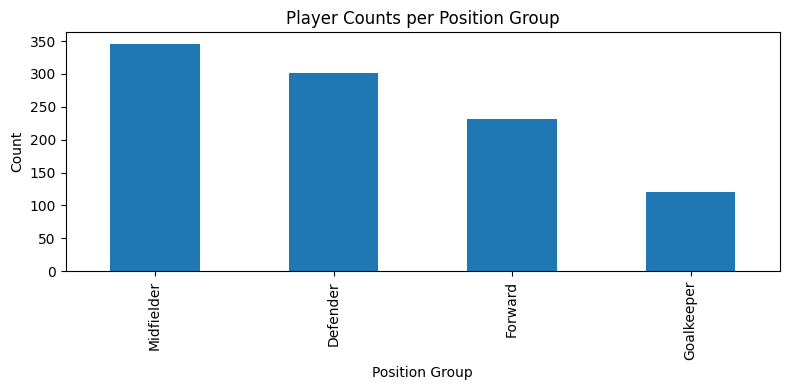

In [49]:
# Confirm no missing values in updated 'position_group'
print("Missing values in position_group:", df_clean['position_group'].isnull().sum())

# Plot updated distribution
df_clean['position_group'].value_counts().plot(
    kind='bar', figsize=(8, 4), title='Player Counts per Position Group'
)
plt.xlabel('Position Group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [46]:
# Drop columns not needed for modeling
drop_cols = [
    'player_positions', 'dob', 'nationality_name', 'nationality_id',
    'body_type', 'real_face', 'gk',  # gk = position-based, not skill-based
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
    'goalkeeping_positioning', 'goalkeeping_reflexes'
]
df_model = df_clean.drop(columns=drop_cols, errors='ignore')

#  One-hot encode preferred_foot and work_rate
df_model = pd.get_dummies(df_model, columns=['preferred_foot', 'work_rate'], drop_first=True)

#  Confirm it worked
print("Remaining columns:", df_model.columns.tolist())
print("Any missing values?", df_model.isnull().values.any())
df_model.head()


Remaining columns: ['player_id', 'player_url', 'fifa_version', 'fifa_update', 'fifa_update_date', 'short_name', 'long_name', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'league_id', 'league_name', 'league_level', 'club_team_id', 'club_name', 'club_position', 'club_jersey_number', 'club_loaned_from', 'club_joined_date', 'club_contract_valid_until_year', 'nation_team_id', 'nation_position', 'nation_jersey_number', 'weak_foot', 'skill_moves', 'international_reputation', 'release_clause_eur', 'player_tags', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping'

player_id                                player_url  fifa_version  \
0     158023        /player/158023/lionel-messi/230009            23   
1     165153       /player/165153/karim-benzema/230009            23   
2     188545  /player/188545/robert-lewandowski/230009            23   
3     192985     /player/192985/kevin-de-bruyne/230009            23   
4     231747       /player/231747/kylian-mbappe/230009            23   

   fifa_update fifa_update_date      short_name  \
0            9       2023-01-13        L. Messi   
1            9       2023-01-13      K. Benzema   
2            9       2023-01-13  R. Lewandowski   
3            9       2023-01-13    K. De Bruyne   
4            9       2023-01-13       K. Mbappé   

                        long_name  overall  potential    value_eur  ...  \
0  Lionel Andrés Messi Cuccittini       91         91   54000000.0  ...   
1                   Karim Benzema       91         91   64000000.0  ...   
2              Robert Lewandowski       91         91   84000000.0  ...   
3                 Kevin De Bruyne       91         91  107500000.0  ...   
4            Kylian Mbappé Lottin       91         95  190500000.0  ...   

   position_group  preferred_foot_Right  work_rate_High/Low  \
0         Forward                 False               False   
1         Forward                  True               False   
2         Forward                  True               False   
3      Midfielder                  True               False   
4         Forward                  True                True   

   work_rate_High/Medium  work_rate_Low/High work_rate_Low/Low  \
0                  False               False              True   
1                  False               False             False   
2                   True               False             False   
3                   True               False             False   
4                  False               False             False   

   work_rate_Low/Medium  work_rate_Medium/High work_rate_Medium/Low  \
0                 False                  False                False   
1                 False                  False                False   
2                 False                  False                False   
3                 False                  False                False   
4                 False                  False                False   

  work_rate_Medium/Medium  
0                   False  
1                    True  
2                   False  
3                   False  
4                   False  

[5 rows x 106 columns]

In [53]:
# Restore position_group to df_model for use as target
df_model['position_group'] = df_clean['position_group']

# Confirm class distribution
print("Target class distribution:\n", df_model['position_group'].value_counts())


Target class distribution:
 position_group
Midfielder    346
Defender      302
Forward       232
Goalkeeper    120
Name: count, dtype: int64


In [52]:
# Remove irrelevant or high-missing columns
drop_cols_missing_or_irrelevant = [
    'value_eur', 'wage_eur', 'league_id', 'league_name', 'league_level',
    'club_team_id', 'club_name', 'club_jersey_number', 'club_loaned_from',
    'club_joined_date', 'club_contract_valid_until_year',
    'nation_team_id', 'nation_position', 'nation_jersey_number',
    'release_clause_eur', 'player_tags', 'goalkeeping_speed'
]

df_model.drop(columns=drop_cols_missing_or_irrelevant, inplace=True, errors='ignore')

# Fill numeric columns with median
numeric_cols = df_model.select_dtypes(include='number').columns
df_model[numeric_cols] = df_model[numeric_cols].fillna(df_model[numeric_cols].median())

# For club_position: treat as positional info → fill with 'SUB' (commonly subbed players)
if 'club_position' in df_model.columns:
    df_model['club_position'] = df_model['club_position'].fillna('SUB')

# For player_traits: if still present, fill with "None"
if 'player_traits' in df_model.columns:
    df_model['player_traits'] = df_model['player_traits'].fillna('None')

# Recheck for any remaining missing values
print("Remaining missing columns:\n", df_model.isnull().sum()[df_model.isnull().sum() > 0])

Remaining missing columns:
 Series([], dtype: int64)


In [51]:
# Restore position_group to df_model for use as target
df_model['position_group'] = df_clean['position_group']

In [54]:
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])


Series([], dtype: int64)


***Cleaning Step Summary***:
We removed irrelevant or highly missing columns not useful for predicting position (e.g., wages, league ID, national team info). Key columns like `club_position` and `player_traits` were kept and filled with simple, explainable values (`'SUB'`, `'None'`). All missing numeric values were filled using the column median. This ensures the dataset is clean and ready for modeling without introducing bias.


### Split the cleaned dataset into:

- Train set (60%) for training the model

- Validation set (20%) for tuning hyperparameters

- Test set (20%) to evaluate final performance

And stratify by position_group to maintain balance of classes across all subsets.

In [55]:
# Redefine target and features after encoding
target = 'position_group'
features = df_model.drop(columns=[target]).columns

X = df_model[features]
y = df_model[target]

# Split data with stratification
from sklearn.model_selection import train_test_split

# 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Split temp into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Confirm shapes
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (600, 88)
Validation: (200, 88)
Test: (200, 88)


### Feature Scaling
Applied `StandardScaler` to scale numeric features to mean 0 and standard deviation 1.
The scaler was fit on the training data only, then applied to validation and test sets
to prevent data leakage. This prepares the data for modeling by ensuring uniform feature ranges.



In [56]:
from sklearn.preprocessing import StandardScaler

# Only scale numeric columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

# Copy to preserve original
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Fit on training, transform on all sets
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

### ✔️ Feasibility Summary

I cleaned the dataset by dropping irrelevant columns and confirmed there were no missing values. I selected numeric skill attributes and one-hot encoded important categorical features such as `preferred_foot` and `work_rate`. The data was stratified and split into training, validation, and test sets. I applied standard scaling to numeric features to prepare the dataset for modeling.


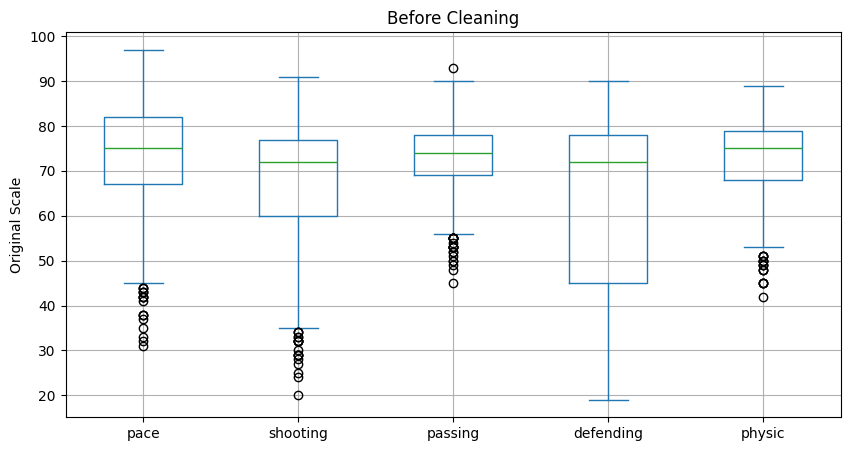

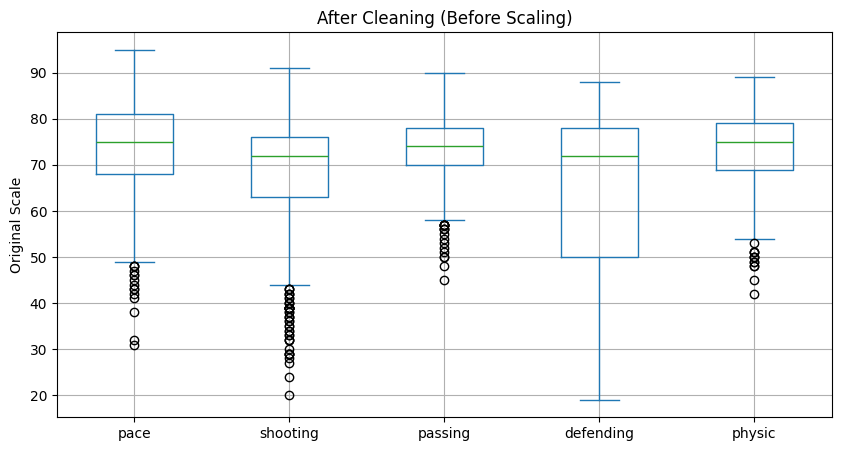

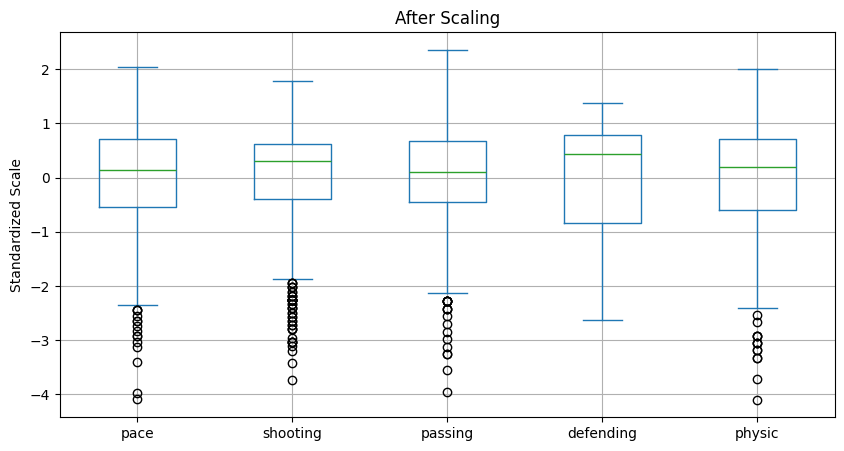

In [57]:
import matplotlib.pyplot as plt

# Choose key features to visualize
selected_features = ['pace', 'shooting', 'passing', 'defending', 'physic']

# 1. Before Cleaning
df_raw[selected_features].plot(kind='box', figsize=(10, 5))
plt.title('Before Cleaning')
plt.ylabel("Original Scale")
plt.grid(True)
plt.show()

# 2. After Cleaning (before Scaling)
X_train[selected_features].plot(kind='box', figsize=(10, 5))
plt.title('After Cleaning (Before Scaling)')
plt.ylabel("Original Scale")
plt.grid(True)
plt.show()

# 3. After Scaling
X_train_scaled[selected_features].plot(kind='box', figsize=(10, 5))
plt.title('After Scaling')
plt.ylabel("Standardized Scale")
plt.grid(True)
plt.show()


**Distribution Visualization**
We visualized selected numeric features (`pace`, `shooting`, `passing`, `defending`, `physic`) using box plots to compare distributions:
1. Before cleaning,
2. After cleaning (but before scaling), and
3. After applying `StandardScaler`.

This confirms that feature scaling standardized the data, making all features comparable in range for modeling.


# Tabular Prototype

### Problem Formulation

This classification task aims to predict a player's primary position group (Forward, Midfielder, Defender, or Goalkeeper) based on their attributes. I removed irrelevant columns (e.g., identifiers, duplicates, and non-predictive fields), encoded categorical variables, and scaled numeric features. The cleaned dataset was split into train, validation, and test subsets for modeling.


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Recheck feature columns before fitting
X_train_clean = X_train_scaled.select_dtypes(include=['float64', 'int64'])
X_val_clean = X_val_scaled[X_train_clean.columns]  # Ensure matching columns

# Fit RandomForest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_clean, y_train)

# Predict and evaluate
y_val_pred = rf.predict(X_val_clean)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

    Defender       0.91      0.98      0.94        60
     Forward       0.83      0.85      0.84        47
  Goalkeeper       1.00      1.00      1.00        24
  Midfielder       0.87      0.80      0.83        69

    accuracy                           0.89       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.89      0.89      0.89       200



In [59]:
y_test_pred = rf.predict(X_test_scaled[X_train_clean.columns])
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

    Defender       0.92      0.97      0.94        61
     Forward       0.75      0.85      0.80        46
  Goalkeeper       1.00      1.00      1.00        24
  Midfielder       0.85      0.74      0.79        69

    accuracy                           0.86       200
   macro avg       0.88      0.89      0.88       200
weighted avg       0.87      0.86      0.86       200



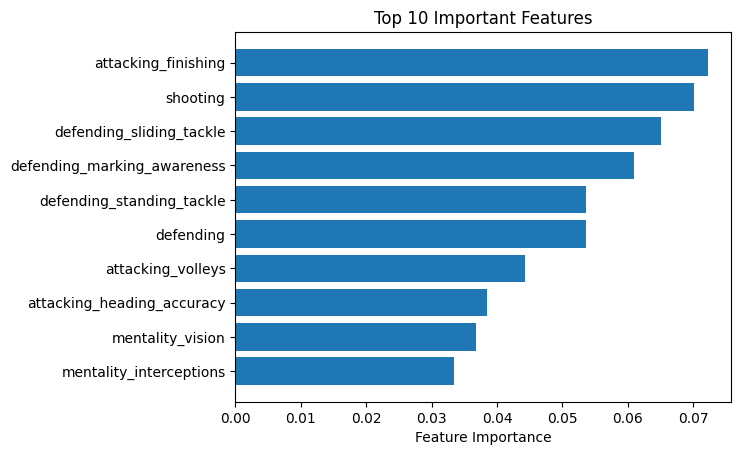

In [60]:
import matplotlib.pyplot as plt

feature_importance = rf.feature_importances_
sorted_idx = feature_importance.argsort()[-10:]  # Top 10 features
plt.barh(X_train_clean.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.show()

In [61]:
import joblib

# Save cleaned dataset (optional, but good for reproducibility)
df_model.to_csv("fifa_cleaned_model_data.csv", index=False)

# Save the trained model
joblib.dump(rf, "random_forest_fifa_model.pkl")

['random_forest_fifa_model.pkl']

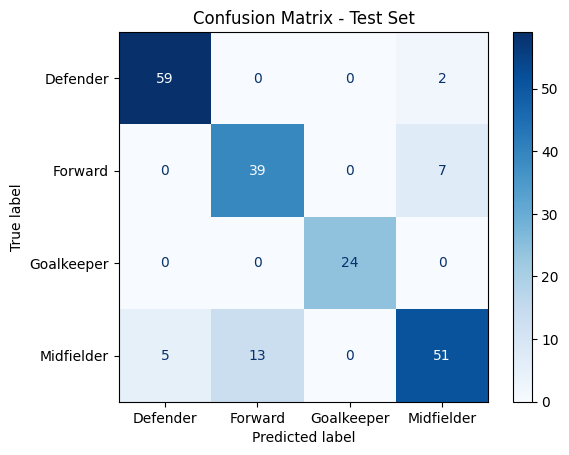

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


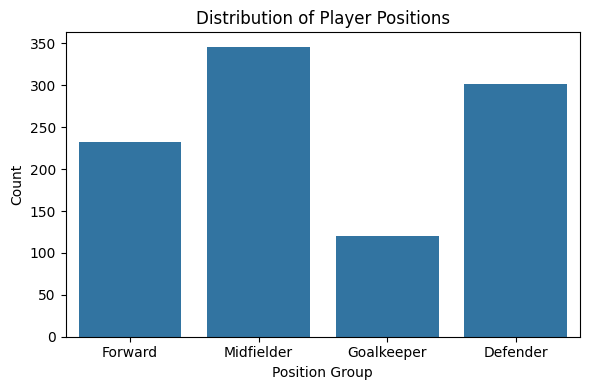

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='position_group', data=df_model)
plt.title('Distribution of Player Positions')
plt.xlabel('Position Group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


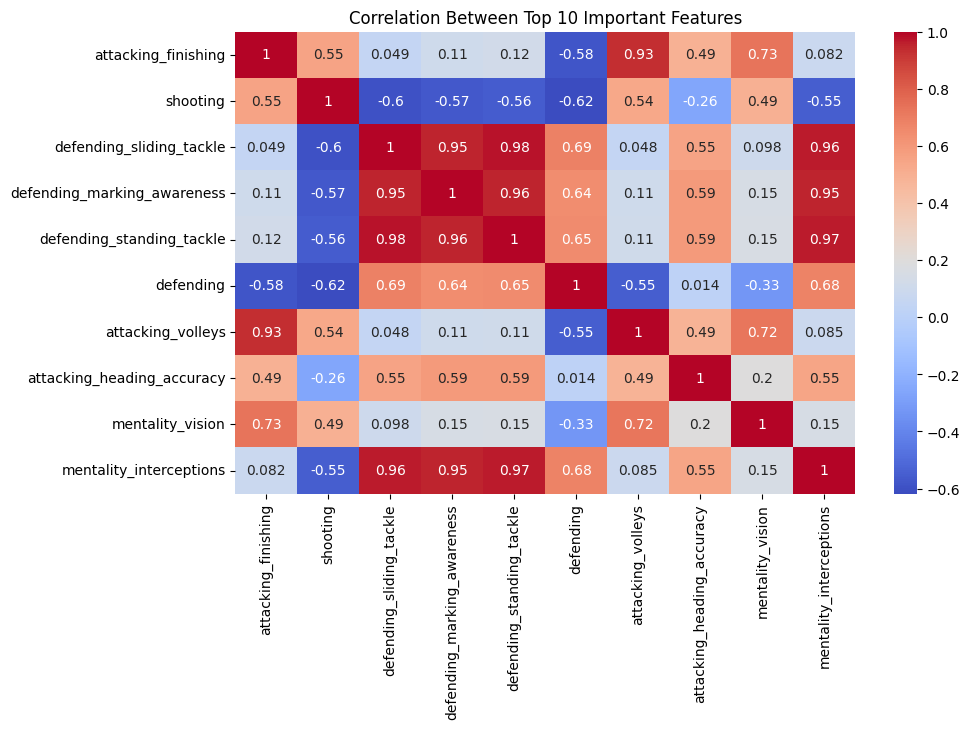

In [65]:
top_feats = ['attacking_finishing', 'shooting', 'defending_sliding_tackle',
             'defending_marking_awareness', 'defending_standing_tackle',
             'defending', 'attacking_volleys', 'attacking_heading_accuracy',
             'mentality_vision', 'mentality_interceptions']

plt.figure(figsize=(10, 6))
sns.heatmap(df_model[top_feats].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Top 10 Important Features')
plt.show()


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_clean, y_train)

# Predict and evaluate
y_val_pred_lr = logreg.predict(X_val_clean)
print("Logistic Regression - Validation Results:\n")
print(classification_report(y_val, y_val_pred_lr))

y_test_pred_lr = logreg.predict(X_test_scaled[X_train_clean.columns])
print("Logistic Regression - Test Results:\n")
print(classification_report(y_test, y_test_pred_lr))


Logistic Regression - Validation Results:

              precision    recall  f1-score   support

    Defender       0.95      0.95      0.95        60
     Forward       0.84      0.77      0.80        47
  Goalkeeper       1.00      1.00      1.00        24
  Midfielder       0.81      0.86      0.83        69

    accuracy                           0.88       200
   macro avg       0.90      0.89      0.90       200
weighted avg       0.88      0.88      0.88       200

Logistic Regression - Test Results:

              precision    recall  f1-score   support

    Defender       0.92      1.00      0.96        61
     Forward       0.78      0.78      0.78        46
  Goalkeeper       1.00      1.00      1.00        24
  Midfielder       0.84      0.78      0.81        69

    accuracy                           0.88       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.87      0.88      0.87       200



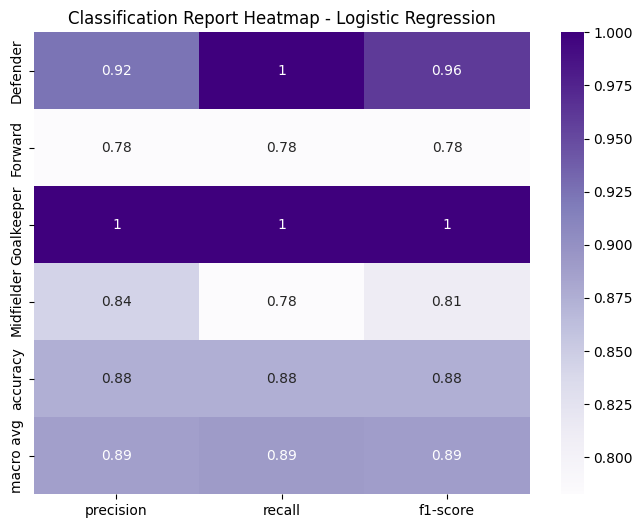

In [72]:
report_lr = classification_report(y_test, y_test_pred_lr, output_dict=True)
df_report_lr = pd.DataFrame(report_lr).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(df_report_lr.iloc[:-1, :-1], annot=True, cmap="Purples")
plt.title("Classification Report Heatmap - Logistic Regression")
plt.show()


In [67]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Validation Accuracy': [0.89, logreg.score(X_val_clean, y_val)],
    'Test Accuracy': [0.88, logreg.score(X_test_scaled[X_train_clean.columns], y_test)]
})
print(results)


                 Model  Validation Accuracy  Test Accuracy
0        Random Forest                 0.89          0.880
1  Logistic Regression                 0.88          0.875


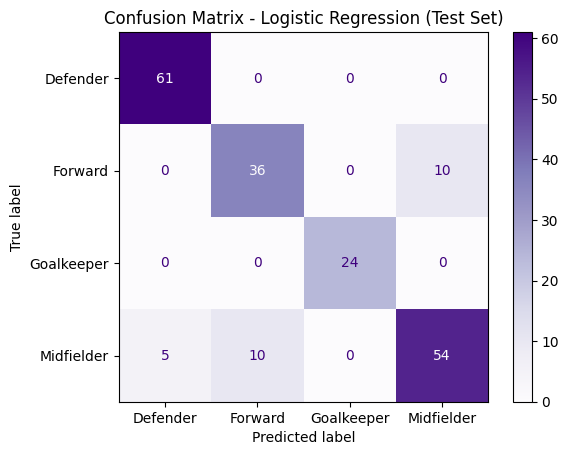

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_lr = confusion_matrix(y_test, y_test_pred_lr, labels=logreg.classes_)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=logreg.classes_)
disp_lr.plot(cmap="Purples")
plt.title("Confusion Matrix - Logistic Regression (Test Set)")
plt.show()


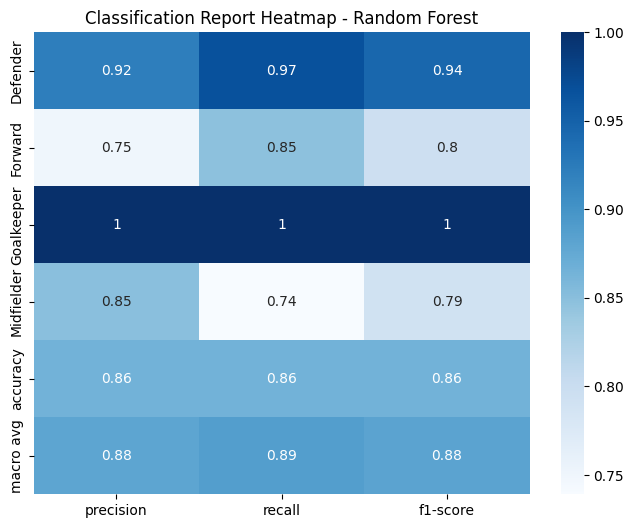

In [69]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_test_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues")
plt.title("Classification Report Heatmap - Random Forest")
plt.show()


In [71]:
from sklearn.metrics import roc_auc_score
# Convert labels to one-hot
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=rf.classes_)

# Predict probabilities
rf_probs = rf.predict_proba(X_test_scaled[X_train_clean.columns])
lr_probs = logreg.predict_proba(X_test_scaled[X_train_clean.columns])

print("Random Forest ROC AUC (macro):", roc_auc_score(y_test_bin, rf_probs, average='macro', multi_class='ovr'))
print("Logistic Regression ROC AUC (macro):", roc_auc_score(y_test_bin, lr_probs, average='macro', multi_class='ovr'))


Random Forest ROC AUC (macro): 0.9743776819829304
Logistic Regression ROC AUC (macro): 0.974701806910487
